<div style="text-align:center; font-size:32px; font-weight:bold; margin-top:20px; margin-bottom:20px;">
    Предсказание риска сердечных приступов
</div>

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

# Вводная часть

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## Задача

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">
    
**Задача:** Разработать модель и интерфейс для предсказания риска сердечного приступа на основе данных пациентов.

**Шаги:**
- Исследовать датасет
- Провести предобработку данных
- Выбрать и обучить модель
- Сделать предсказания на тестовой выборке
- Подготовить скрипты и библиотеки для обработки данных и предсказания на тестовой выборке
- Написать инструменты для тестирования
- Оформить документацию


<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## Описание данных

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

- id
- Антропометрические параметры и доход
    - `age`
    - `gender`
    - `obesity`
    - `bmi`- индекс массы тела
    - `income`
- Привычки
    - `smoking`
    - `alc` - alcohol consumption
    - `exercise_hpw` - exercise hours per week
    - `phys_dpw` - physical activity days per week
    - `sleep_hpd` - sleep hours per day
    - `stress` - stress level
    - `sedentary_hpd` - sedentary hours per day (сидячий образ жизни)
    - `diet`
- Давление и ритм
    - `sys_bp` - systolic blood pressure
    - `dia_bp`- diastolic blood pressure
    - `hr` - heart_rate
- История болезней
    - `diabetes`
    - `fam_hist` - family history
    - `prev_heart` - previous heart problems
    - `meds` - medication use
- Биохимия крови
    - `chol` - cholesterol
    - `trig` - triglycerides
    - `glucose` - blood sugar
    - `ckmb` - CK-MB (биомаркер повреждения сердца)
    - `troponin` - главный маркер инфаркта миокарда
- Таргет
    - `heart_risk` - высокий или низкий риск поражения сердца


<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Импорт библиотек и базовые настройки

In [1]:
# Отключение оповещений
import optuna
import warnings
import os
# отключение обычныых предупреждений Python
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning,
                        message=".*CatBoostClassifier.*__sklearn_tags__.*")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="sklearn")
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
optuna.logging.set_verbosity(optuna.logging.ERROR)
os.environ["CATBOOST_SUPPRESS_WARNINGS"] = "1"

In [2]:
# Стандартные библиотеки
import random

# Сторонние библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import sklearn
from pathlib import Path
import time
import lightgbm as lgb
import joblib

# Подготовка данных, кросс-валидация и подбор гиперпараметров
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import (
    train_test_split,
    KFold, StratifiedKFold, # кросс-валидация
    GridSearchCV)           # подбор гиперпараметров
from optuna.integration import OptunaSearchCV    # подбор гиперпараметров
from optuna.distributions import IntDistribution, CategoricalDistribution, FloatDistribution

# Модели
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier

# Метрики
from sklearn.metrics import make_scorer, fbeta_score, f1_score, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from matplotlib import rcParams

# Интерпретация
from sklearn.inspection import permutation_importance
import shap

# Пайплайны
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Константы
RANDOM_STATE = 42

In [3]:
# Оформление
from IPython.display import display, HTML, Markdown

# Стили таблиц
styles = [{'selector': 'th',
           'props': [('font-size', '10pt'),
                     ('white-space', 'normal'),
                     ('min-width', '100px'),
                     ('text-align', 'center')]},
          {'selector': 'td',
           'props': [('font-size', '10pt'),
                     ('white-space', 'normal'),
                     ('text-align', 'center')]}]

# Настройки отображения
rcParams['figure.figsize'] = (8, 5)             # увеличиваем дефолтный размер графиков
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Функции

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
   
### Для описания данных descr

In [4]:
def descr(df):
    print(f"Кол-во строк: {df.shape[0]}")
    print(f"Кол-во столбцов: {df.shape[1]}")
    print('\nПервые 5 строк')
    display(df.head())
    descr = df.describe(include='all').T
    descr['dtype'] = df.dtypes
    descr['unique'] = df.nunique()
    descr = descr[['dtype'] \
                  + [col for col in descr.columns if col != 'dtype']]
    print('\nОписание столбцов')
    display(descr)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Для отрисовки draw_histboxes

In [5]:
def draw_histboxes(df, axes, titles, x_labels,
                   y_label='count',
                   cols=None, bins=None):
    '''
    На каждый столбец рисует 2 графика: гистограмму + боксплот
    axes: массив осей для рисования
    cols: список столбцов для отрисовки на графиках
    titles: список заголовков графиков
    x_labels: список подписей для осей X
    y_label: подпись для оси Y
    bins: кол-во бинов в гистограмме
    '''
    if isinstance(df, pd.Series):
        df = df.to_frame()
        cols = [df.columns[0]]
    bins = int(np.log2(df.shape[0])+1) if bins is None else bins  # правило Стёрджеса
    axes = np.atleast_1d(axes).ravel() 
    for i, (col, x_label, title) in enumerate(zip(cols, x_labels, titles)):
        ax_hist = axes[i*2]
        ax_box = axes[i*2+1]
        # гистограмма
        sns.histplot(data=df, x=col, bins=bins,
                     linewidth=0.2, edgecolor='white', color='royalblue',
                     ax=ax_hist, alpha=0.7)
        ax_hist.set_title(title, fontsize=10, fontweight='bold')
        ax_hist.set_xlabel(x_label, fontsize=9)
        ax_hist.set_ylabel(y_label, fontsize=9)
        ax_hist.grid(axis='y')
        ax_hist.set_axisbelow(True)
        
        # боксплот
        sns.boxplot(data=df, x=col, width=0.6, ax=ax_box,
                    boxprops=dict(facecolor='royalblue', alpha=0.7))
        ax_box.set_title(title, fontsize=10, fontweight='bold')
        ax_box.set_xlabel(x_label, fontsize=9)
        ax_box.set_axisbelow(True)
        
        # подписи на боксплоте
        ymin, ymax = ax_box.get_ylim()
        y_offset = (ymax - ymin) * 0.05
        y_position = (ymin + ymax) / 2 + y_offset 
        xmin, xmax = ax_box.get_xlim()
        x_offset = (xmax - xmin) * 0.01
        minimum = df[col].min()
        median = df[col].median()
        maximum = df[col].max()
        ax_box.text(minimum + x_offset, y_position, round(minimum, 1), ha='left')
        ax_box.text(median + x_offset, y_position, round(median, 1), ha='left')
        ax_box.text(maximum - x_offset, y_position, round(maximum, 1), ha='right')

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Для отрисовки draw_bars

In [6]:
def draw_bars(df, axes, cols, titles, xlabels, target,
              ylabel='count',
              padding=3, ylim_mult=1.3, show_target='yes', bartype='vertical'):
    '''
    axes: массив осей для рисования
    cols: список столбцов для отрисовки на графиках
    titles: список заголовков графиков
    xlabels: список подписей для осей X
    target: столбец, среднее значение по которому подписывать на диаграмме
    ylabel: подпись для оси Y
    padding: отступ подписей столбцов
    ylim_mult: множитель для верхней границы оси Y
    show_target: нужно ли показывать среднее значение целевой переменной
    '''
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for i, col in enumerate(cols):
        counts = df[col].value_counts().sort_index()
        perc = (counts / counts.sum() * 100).round().astype('int')
        if show_target == 'yes':
            target_avg = df.groupby(col)[target].mean().reindex(counts.index).round(2)
            labels = [f"{val} /{p}%\n{target_avg[ind]}" if len(counts)<9
                      else f"{p}%\n{target_avg[ind]}"
                      for ind, val, p in zip(counts.index, counts.values, perc)]
        else:
            labels = [f"{val} /{p}%" if len(counts)<9
                      else f"{p}%"
                      for val, p in zip(counts.values, perc)]                  
        bars = axes[i].bar(x=counts.index.round(3).astype(str), height=counts.values, alpha=0.9)
        axes[i].set_xlabel(xlabels[i], fontsize=9)
        axes[i].set_ylabel(ylabel, fontsize=9)
        axes[i].set_ylim(0, counts.values.max()*ylim_mult)
        axes[i].grid(axis='y')
        axes[i].bar_label(bars, labels, padding=padding, fontsize=9)
        axes[i].set_title(titles[i], fontsize=10, fontweight='bold')
        axes[i].set_axisbelow(True) 

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Для отрисовки draw_scatters

In [7]:
def draw_scatters(df, axes,
                  x_cols, x_labels, x_discretes,
                  y_col, y_label,
                  titles, hue=None):
    '''
    df: датафрейм
    axes: массив осей для рисования
    x_cols: список столбцов для осей X
    x_labels: список подписей для осей X
    x_discretes: список длины len(x_cols), в котором 1 значит, что переменная дискретная
    y_col: столбец для оси Y
    y_label: подпись для оси Y
    titles: список заголовков графиков
    hue: столбец для расскраски
    '''
    axes = np.atleast_1d(axes).ravel()
    for ax, x_col, x_label, is_discr, title in zip(axes, x_cols, x_labels, x_discretes, titles):
        plot_func = sns.stripplot if is_discr else sns.scatterplot
        plot_kwargs = dict(data=df, x=x_col, y=y_col, alpha=0.8, ax=ax)
        if hue is not None:
            plot_kwargs.update({'hue': hue, 'palette': 'Blues'})
        if is_discr:
            plot_kwargs.update({'linewidth': 0.5, 'edgecolor':'white', 'jitter':True, 'dodge':True})
        else:
            plot_kwargs.update({'s': 30})
        
        plot_func(**plot_kwargs)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel(x_label, fontsize=9)
        ax.set_ylabel(y_label, fontsize=9)
        if hue is not None:
            ax.legend(loc='upper right')

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Для исправления пола fix_gender

In [8]:
def fix_gender(df):
    col = df.iloc[:,0]
    col_str = col.astype(str).str.lower()
    return col_str.replace({'1.0':1, 'male':1, '0.0':0, 'female':0}).values.reshape(-1,1)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Для удаления признаков-утечек

In [9]:
def drop_leak(df, leak_cols):
    return df.drop(leak_cols, axis=1, errors='ignore')

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Трансформер ReplaceBlanksWithNaN

In [10]:
# Создаем класс для замены пробелов на nan
class ReplaceBlanksWithNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # это простой трансформер без обучения, поэтому fit ничего не делает
    def transform(self, X):
        return X.replace(r'^\s*$', np.nan, regex=True)  # замена любого кол-ва пробелов или пусто
    def get_feature_names_out(self, input_features=None):
        return input_features

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### f2_score

In [11]:
f2_score = make_scorer(fbeta_score, beta=2)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Для печати метрик модели

In [12]:
def print_metrics(y_real, y_pred, y_pred_proba):
    metrics = {
        'F1-score': f1_score(y_real, y_pred, zero_division=0)*100,
        'F2-score': fbeta_score(y_real, y_pred, beta=2, zero_division=0)*100,
        'Recall': recall_score(y_real, y_pred, zero_division=0)*100,
        'Precision': precision_score(y_real, y_pred, zero_division=0)*100,
        'Accuracy': accuracy_score(y_real, y_pred)*100,
        'ROC-AUC': roc_auc_score(y_real, y_pred_proba)*100,
        'Share of 1': sum(y_pred)/len(y_pred)*100
    }
    for name, value in metrics.items():
        print(f"{name:<12}{value:.1f}")

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
# Загрузка и поверхностное изучение данных

In [13]:
# def load_csv(filename):
#     path = Path('..') / filename
#     if not path.exists():
#         raise FileNotFoundError(f"Файл '{filename}' не найден в директории ноутбука")
#     return pd.read_csv(path)

# df1 = load_csv('heart_train.csv')
# df2 = load_csv('heart_test.csv')

In [14]:
def load_csv(filename):
    path = Path(filename)
    if not path.exists():
        raise FileNotFoundError(f"Файл '{path}' не найден в директории ноутбука")
    return pd.read_csv(path)

df1 = load_csv('heart_train.csv')
df2 = load_csv('heart_test.csv')

In [15]:
descr(df1)

Кол-во строк: 8685
Кол-во столбцов: 28

Первые 5 строк


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047



Описание столбцов


,dtype,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,int64,8685.0,8685,NaN,NaN,4342.0,2507.287877,0.0,2171.0,4342.0,6513.0,8684.0
Age,float64,8685.0,77,NaN,NaN,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
Cholesterol,float64,8685.0,282,NaN,NaN,0.50107,0.284716,0.0,0.267857,0.49978,0.746429,1.0
Heart rate,float64,8685.0,87,NaN,NaN,0.050658,0.023453,0.0,0.03483,0.050412,0.065995,1.0
Diabetes,float64,8442.0,2,NaN,NaN,0.652097,0.476333,0.0,0.0,1.0,1.0,1.0
Family History,float64,8442.0,2,NaN,NaN,0.489576,0.499921,0.0,0.0,0.0,1.0,1.0
Smoking,float64,8442.0,2,NaN,NaN,0.902867,0.296157,0.0,1.0,1.0,1.0,1.0
Obesity,float64,8442.0,2,NaN,NaN,0.498342,0.500027,0.0,0.0,0.0,1.0,1.0
Alcohol Consumption,float64,8442.0,2,NaN,NaN,0.60199,0.489517,0.0,0.0,1.0,1.0,1.0
Exercise Hours Per Week,float64,8685.0,7933,NaN,NaN,0.503378,0.28481,0.0,0.263286,0.50211,0.748709,1.0


In [16]:
descr(df2)

Кол-во строк: 966
Кол-во столбцов: 27

Первые 5 строк


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825



Описание столбцов


,dtype,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,int64,966.0,966,NaN,NaN,482.5,279.00448,0.0,241.25,482.5,723.75,965.0
Age,float64,966.0,73,NaN,NaN,0.452916,0.231068,0.044944,0.247191,0.460674,0.640449,0.853933
Cholesterol,float64,966.0,266,NaN,NaN,0.488181,0.282039,0.0,0.24375,0.49978,0.710714,0.996429
Heart rate,float64,966.0,76,NaN,NaN,0.051644,0.035502,0.0,0.036664,0.050412,0.065995,1.0
Diabetes,float64,935.0,2,NaN,NaN,0.656684,0.47507,0.0,0.0,1.0,1.0,1.0
Family History,float64,935.0,2,NaN,NaN,0.481283,0.499917,0.0,0.0,0.0,1.0,1.0
Smoking,float64,935.0,2,NaN,NaN,0.898396,0.302289,0.0,1.0,1.0,1.0,1.0
Obesity,float64,935.0,2,NaN,NaN,0.516578,0.499993,0.0,0.0,1.0,1.0,1.0
Alcohol Consumption,float64,935.0,2,NaN,NaN,0.583957,0.493165,0.0,0.0,1.0,1.0,1.0
Exercise Hours Per Week,float64,966.0,924,NaN,NaN,0.490706,0.284902,0.000336,0.243431,0.50211,0.734425,0.998938


<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

- Видим, что большая часть данных уже масштабирована: принимает значение от 0 до 1. Кроме диеты, стресса, физ.активности и пола
- Достаточно много данных, принимающих значание только 0 или 1, они типа float, не вижу необходимости переводить в bool
- В обоих датасетах есть пропуски в отдельных признаках. Причем и в трейне и в тесте кол-во пропусков в столбцах с пропусками совпадает между собой. Нужно проверить, это одни и те же строки или нет. Пропусков не так много, но т.к. в тесте мы не можем удалять строки, то скорее всего лучшим решением будет заполнить пропуски медианой и модой.
- id нужно сделать индексом, и убрать лишний столбец `Unnamed: 0`

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

# Предобработка данных  

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## id в индекс, янвые дубликаты

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

- id уникальны в каждой таблице
- Проверим, что они не пересекаются между собой - не пересекаются 
- Удалим столбец `Unnamed: 0` и сделаем столбец `id` индексом в каждом датасете
- Проверим, есть ли полные дубликаты после проведенных манипуляций - их нет

In [17]:
# проверяем пересечения - кол-во id (строк) в тренировочной выборке, которые есть в тестовой
print(df1['id'].isin(df2['id']).sum())

0


In [18]:
# сделаем id индексом и удалим лишний столбец с нумерацией
df1 = df1.set_index('id')
df1 = df1.drop('Unnamed: 0', axis=1)
df2 = df2.set_index('id')
df2 = df2.drop('Unnamed: 0', axis=1)
print(f"Кол-во столбцов в трейне: {df1.shape[1]}. Кол-во столбцов в тесте: {df2.shape[1]}")

Кол-во столбцов в трейне: 26. Кол-во столбцов в тесте: 25


In [19]:
# проверяем наличие явных дубликатов
print(df1.duplicated().sum())
print(df2.duplicated().sum())

0
0


<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## Переименование столбцов

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Скорректируем имена столбцов на короткие в стиле snake case

In [20]:
col_names_dict = {
    'Age': 'age',
    'Cholesterol': 'chol',
    'Heart rate': 'hr',
    'Diabetes': 'diabetes',
    'Family History': 'fam_hist',
    'Smoking': 'smoking',
    'Obesity': 'obesity',
    'Alcohol Consumption': 'alc',
    'Exercise Hours Per Week': 'exercise_hpw',
    'Diet': 'diet',
    'Previous Heart Problems': 'prev_heart',
    'Medication Use': 'meds',
    'Stress Level': 'stress',
    'Sedentary Hours Per Day': 'sedentary_hpd',
    'Income': 'income',
    'BMI': 'bmi',
    'Triglycerides': 'trig',
    'Physical Activity Days Per Week': 'phys_dpw',
    'Sleep Hours Per Day': 'sleep_hpd',
    'Heart Attack Risk (Binary)': 'heart_risk',
    'Blood sugar': 'glucose',
    'CK-MB': 'ckmb',
    'Troponin': 'troponin',
    'Gender': 'gender',
    'Systolic blood pressure': 'sys_bp',
    'Diastolic blood pressure': 'dia_bp',
}
df1 = df1.rename(columns=col_names_dict)   
df2 = df2.rename(columns=col_names_dict)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## Утечки признаков

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Среди признаков есть тропонин и CK-MB (креатинкиназа МВ), они являются маркерами уже наступившего инфаркта миокарда.  И хотя корреляции с целевым признаком нет, такие данные нужно исключить из моделей.

In [21]:
# корреляции
print(round(df1['heart_risk'].corr(df1['troponin']),2))
print(round(df1['heart_risk'].corr(df1['ckmb']),2))
print(round(df1['troponin'].corr(df1['ckmb']),2))

0.01
-0.01
-0.0


In [22]:
# убираем эти признаки из датасета
# df1 = df1.drop(['troponin', 'ckmb'], axis=1)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## Пропуски

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Проверим, что пропуски в одних и тех же столбцах - да, так и есть. 

In [23]:
# смотрим кол-во строк с каждым числом пропусков
print(df1.isna().sum(axis=1).value_counts())
print(df2.isna().sum(axis=1).value_counts())

0    8442
9     243
Name: count, dtype: int64
0    935
9     31
Name: count, dtype: int64


In [24]:
df1_gaps = df1.shape[0] - df1['diabetes'].count()  # тут можно было взять любой столбец с пропусками
df2_gaps = df2.shape[0] - df2['diabetes'].count()
print(f"{df1_gaps} пропусков, {round(df1_gaps/df1.shape[0]*100,1)}%")
print(f"{df2_gaps} пропусков, {round(df2_gaps/df2.shape[0]*100,1)}%")

243 пропусков, 2.8%
31 пропусков, 3.2%


<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Пропуски

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

- В столбце с полом 4 уникальных значения, нужно исправить.
- Видим, что пол закодирован и как Male/Female, и как 1/0.
- Проверим, что подразумевается по 1/0 через проверку среднего значения по столбцу дохода

In [25]:
print(df1['gender'].value_counts(), '/n')
print(df2['gender'].value_counts())

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64 /n
gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64


In [26]:
df1.loc[:, ['gender', 'income']].groupby('gender')['income'].mean()

gender
0.0       0.494889
1.0       0.494889
Female    0.492868
Male      0.497491
Name: income, dtype: float64

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Выясняется, что в строках, где `gender = 1/0` доход одинаковый. Подозрительно, давайте проверим значение целевой переменной в разрезе `gender`


In [27]:
df1.groupby('gender').mean()

,age,chol,hr,diabetes,fam_hist,smoking,obesity,alc,exercise_hpw,diet,prev_heart,meds,stress,sedentary_hpd,income,bmi,trig,phys_dpw,sleep_hpd,heart_risk,glucose,ckmb,troponin,sys_bp,dia_bp
gender,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.474881,0.499780,0.079196,NaN,NaN,NaN,NaN,NaN,0.502110,3.000000,NaN,NaN,NaN,0.499920,0.494889,0.494774,0.503603,NaN,0.504621,0.000000,0.204307,0.055945,0.015421,0.396885,0.367148
1.0,0.487468,0.499780,0.059825,NaN,NaN,NaN,NaN,NaN,0.502110,3.000000,NaN,NaN,NaN,0.499920,0.494889,0.494774,0.503603,NaN,0.504621,0.000000,0.204507,0.066234,0.038898,0.390281,0.351893
Female,0.442662,0.499036,0.050508,0.649219,0.482812,0.679688,0.500781,0.608594,0.504018,1.011328,0.491406,0.502344,5.561328,0.495060,0.492868,0.494595,0.500901,3.539453,0.506510,0.351562,0.227146,0.049947,0.036815,0.453291,0.502217
Male,0.451771,0.502009,0.050058,0.653349,0.492520,1.000000,0.497280,0.599116,0.503152,0.997280,0.497110,0.500680,5.463788,0.500919,0.497491,0.497805,0.507557,3.494730,0.502493,0.359232,0.228369,0.046786,0.036890,0.451373,0.501435


In [28]:
df2.groupby('gender').mean()

,age,chol,hr,diabetes,fam_hist,smoking,obesity,alc,exercise_hpw,diet,prev_heart,meds,stress,sedentary_hpd,income,bmi,trig,phys_dpw,sleep_hpd,glucose,ckmb,troponin,sys_bp,dia_bp
gender,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.464419,0.499780,0.049292,NaN,NaN,NaN,NaN,NaN,0.502110,3.000000,NaN,NaN,NaN,0.499920,0.494889,0.494774,0.503603,NaN,0.504621,0.214756,0.008654,0.001791,0.336201,0.325581
1.0,0.482635,0.499780,0.095950,NaN,NaN,NaN,NaN,NaN,0.502110,3.000000,NaN,NaN,NaN,0.499920,0.494889,0.494774,0.503603,NaN,0.504621,0.153611,0.058689,0.056903,0.384164,0.399577
Female,0.443525,0.474098,0.050876,0.652632,0.501754,0.666667,0.473684,0.547368,0.479839,0.936842,0.519298,0.487719,5.484211,0.511967,0.479831,0.498036,0.497863,3.557895,0.523392,0.224774,0.050228,0.037499,0.452541,0.505916
Male,0.455869,0.493802,0.050514,0.658462,0.472308,1.000000,0.535385,0.600000,0.494926,1.012308,0.483077,0.489231,5.266154,0.504737,0.485915,0.466626,0.480981,3.393846,0.508205,0.226359,0.048477,0.033513,0.448486,0.498497


<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Окей, строки с gender 0 и 1:
- имеют таргет 0
- часть признаков у них с одинаковыми значениями - видимо это были пропуски и их заполнили.  
- в этих строках есть еще много незаполненных пропусков

Все эти строки выглядят **аномальными**. Кажется очень логичным удалить эти строки в train. Но при удалении мы теряем все корреляции (см блок с корреляционным анализом).
Поэтому мы оставим `df1` с этими строками. При проверке качества моделей попробуем удалить строки с NA

In [29]:
# исправим столбец с полом
df1['gender'] = fix_gender(df1[['gender']])
df2['gender'] = fix_gender(df2[['gender']])

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## Преобразование типов

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Распределим признаки по их смыслу  
    - `num_cols_cont` - числовые непрерывные столбцы
    - `num_cols_discrete` - дискретные числовые столбцы
    - `bool_cols` - булевы столбцы, но типа float. Для моделей не обязательно их преобразовывать, оставляем так 
    - `ord_cols` - порядковые столбцы

Преобразывывать тип имеет смысл только у целевой переменной - в int. Остальные не обязательно т.к. деревья, используемые далее, справляются с текущими типами.

In [30]:
num_cols_cont = ['age', 'chol', 'hr', 'exercise_hpw', 'sedentary_hpd', 'income', 'bmi', 'trig', 'glucose', 'ckmb', 'troponin', 'sys_bp', 'dia_bp']
num_cols_discrete = ['sleep_hpd', 'phys_dpw']  # 'phys_dpw' не масштабирован
bool_cols = ['diabetes', 'fam_hist', 'smoking', 'obesity', 'alc', 'prev_heart', 'meds', 'gender']
ord_cols = ['stress', 'diet']
target = 'heart_risk'

In [31]:
# преобразовываем типы столбцов
df1[target] = df1[target].astype(int)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

# EDA

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">

## Исследовательский анализ

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">
    
Построим:
- **Столбчатые** диаграммы - для булевых и порядковых признаков
- **Гистолграммы** и **ящики с усами** - для количественных признаков

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Столбчатые диаграммы (train)

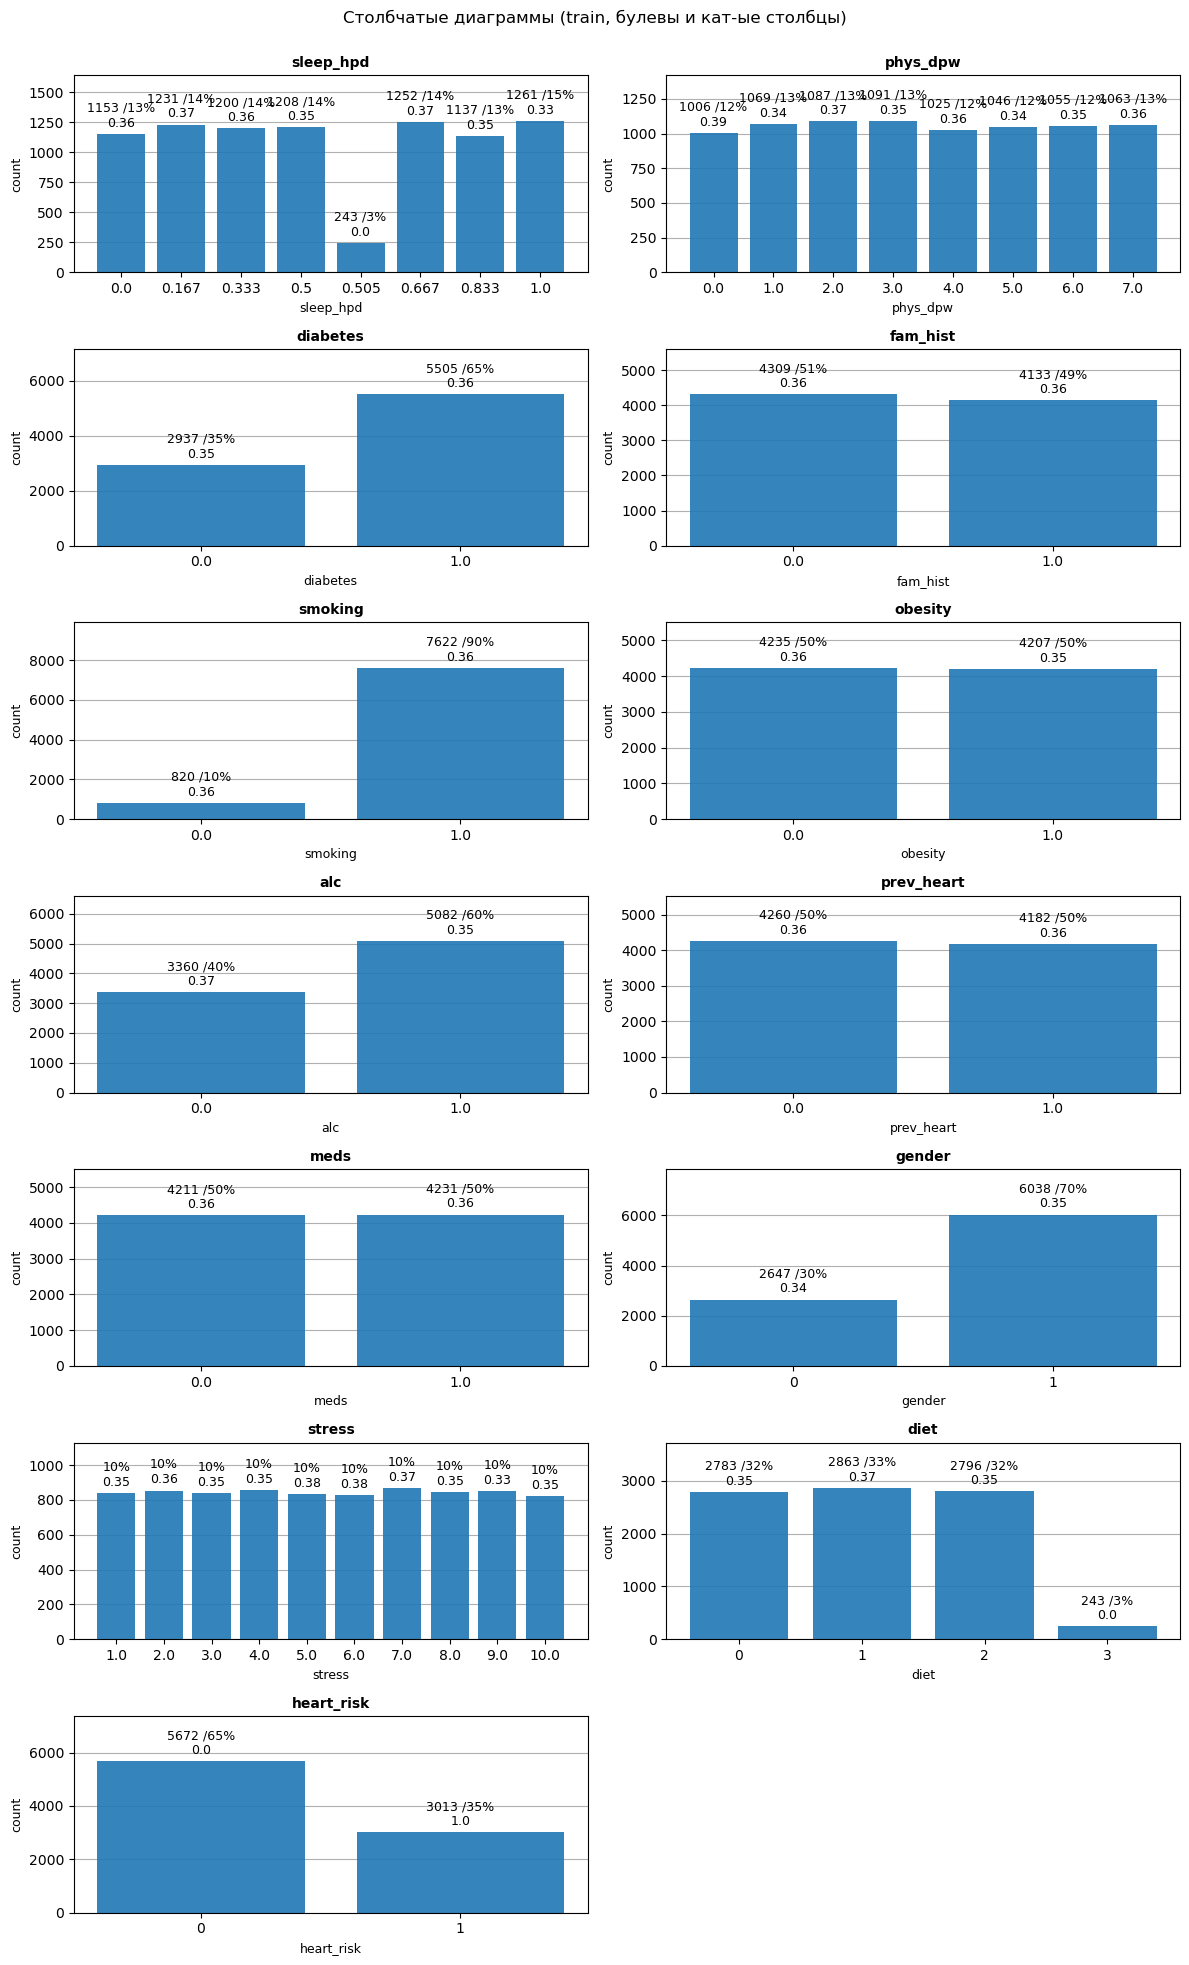

In [32]:
# Столбчатые диаграммы
cols = num_cols_discrete + bool_cols + ord_cols + [target]
titles = cols.copy()
xlabels = cols.copy()
fig, axes = plt.subplots(7, 2, figsize=(12, 20))
axes = axes.flatten()
axes[-1].axis('off')
draw_bars(df1, axes, cols, titles, xlabels, target='heart_risk')
plt.suptitle('Столбчатые диаграммы (train, булевы и кат-ые столбцы)')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

<div style="background: #ebf5ff; padding: 20px; border-left: 20px solid #00264d; border-radius: 15px 15px 15px 15px;">

- Есть небольшой дисбаланс классов - 36% с таргетом 1, 64% - с таргетом 0
- Интересно, что мы не видим разницы в среднем риске инфаркта на разных значениях признаков.

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Столбчатые диаграммы (test)

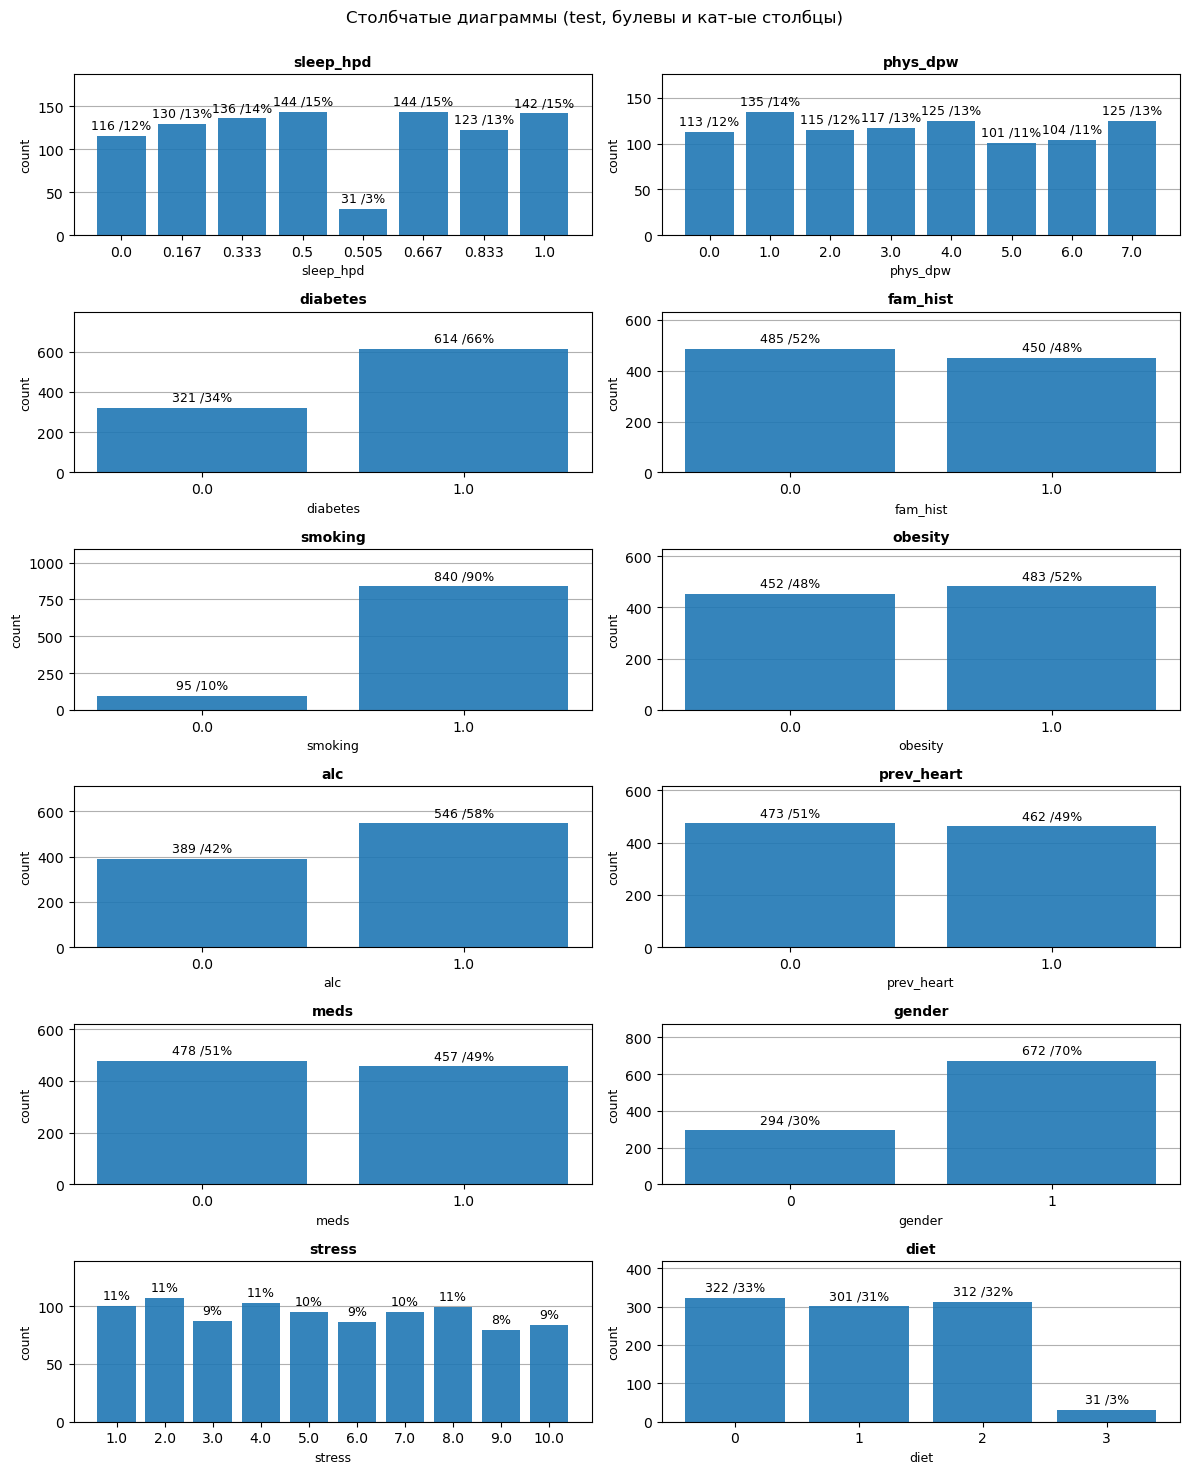

In [33]:
# Столбчатые диаграммы
cols = num_cols_discrete + bool_cols + ord_cols
titles = cols.copy()
xlabels = cols.copy()
fig, axes = plt.subplots(6, 2, figsize=(12, 15))
axes = axes.flatten()
draw_bars(df2, axes, cols, titles, xlabels, target='heart_risk', show_target='no')
plt.suptitle('Столбчатые диаграммы (test, булевы и кат-ые столбцы)')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

<div style="background: #ebf5ff; padding: 20px; border-left: 20px solid #00264d; border-radius: 15px 15px 15px 15px;">
    
- В тесте мы видим примерно такое же распределение значений по булевым и категориальным столбцам.  
- Интересно, что т.к. тест мы не чистили от пропусков, тут остались строки, где `diet = 3`.  
  Все эти "странные" строки с пропусками имеют отдельный показатель диеты. Предполагаю, что 3 - это просто маркер отсутсвтия данных для столбца `diet`.

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Гистограммы и ящики с усами (train)

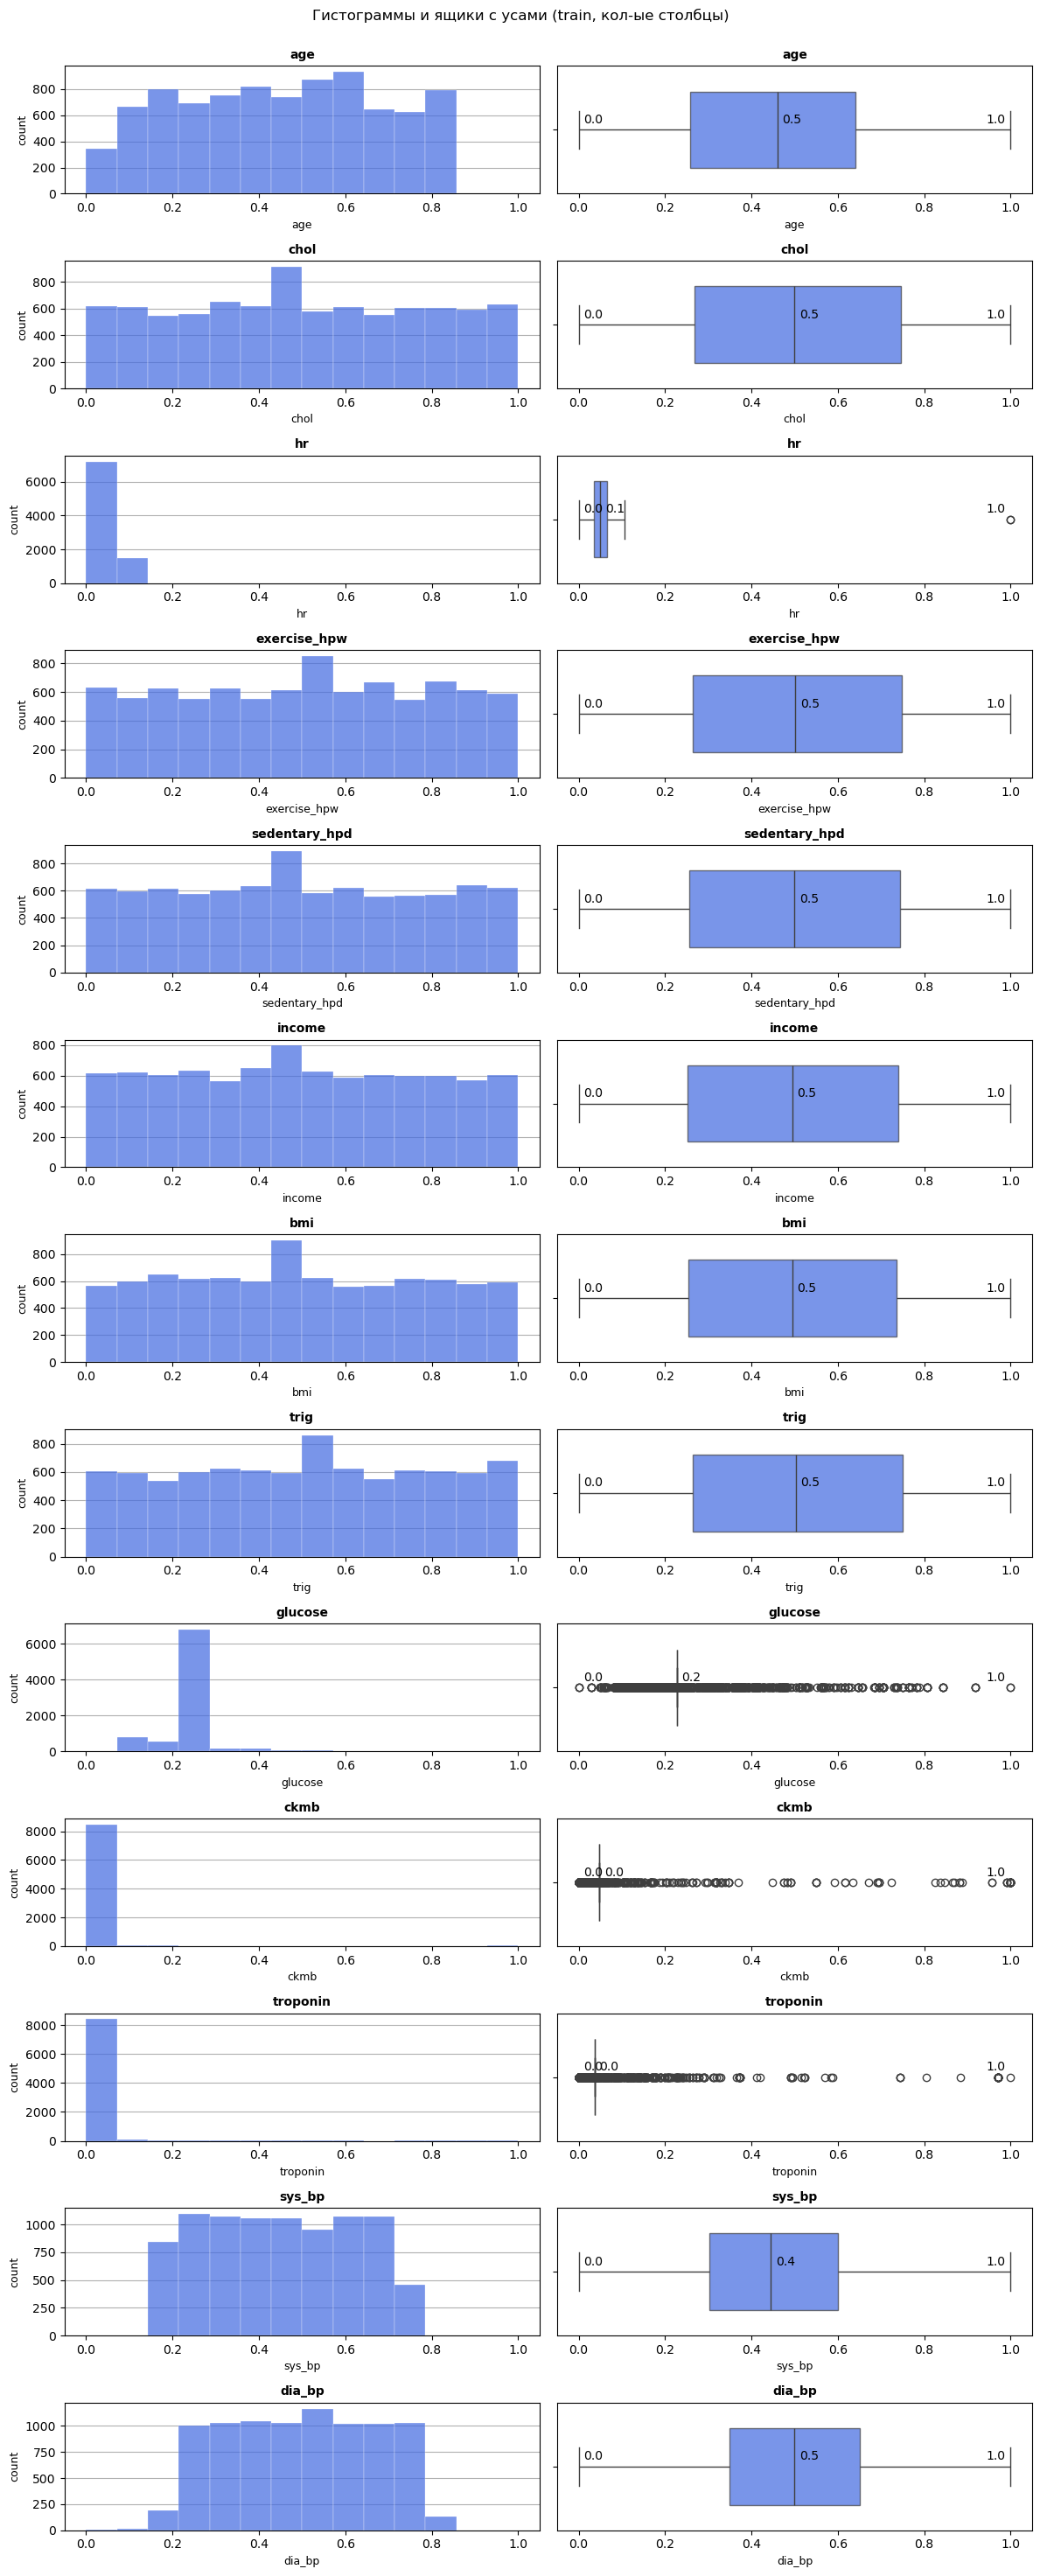

In [34]:
# Гистограммы и ящики с усами
cols = num_cols_cont
titles = cols.copy()
x_labels = cols.copy()
fig, axes = plt.subplots(13, 2, figsize=(12, 30))
axes = axes.flatten()
draw_histboxes(df1, axes, titles, x_labels, cols=cols)
plt.suptitle('Гистограммы и ящики с усами (train, кол-ые столбцы)')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

<div style="background: #ebf5ff; padding: 20px; border-left: 20px solid #00264d; border-radius: 15px 15px 15px 15px;">

Есть длинные хвосты в 3х столбцах. Запишем, что можно будет убрать такие наблюдения:  
    - `glucose` - наблюдения > 0.8  
    - `ckmb` - наблюдения > 0.4 (в последствии столбец удалили)  
    - `troponin` - наблюдения > 0.4 (в последствии столбец удалили)  
Но пока убирать не будем.

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Гистограммы и ящики с усами (test)

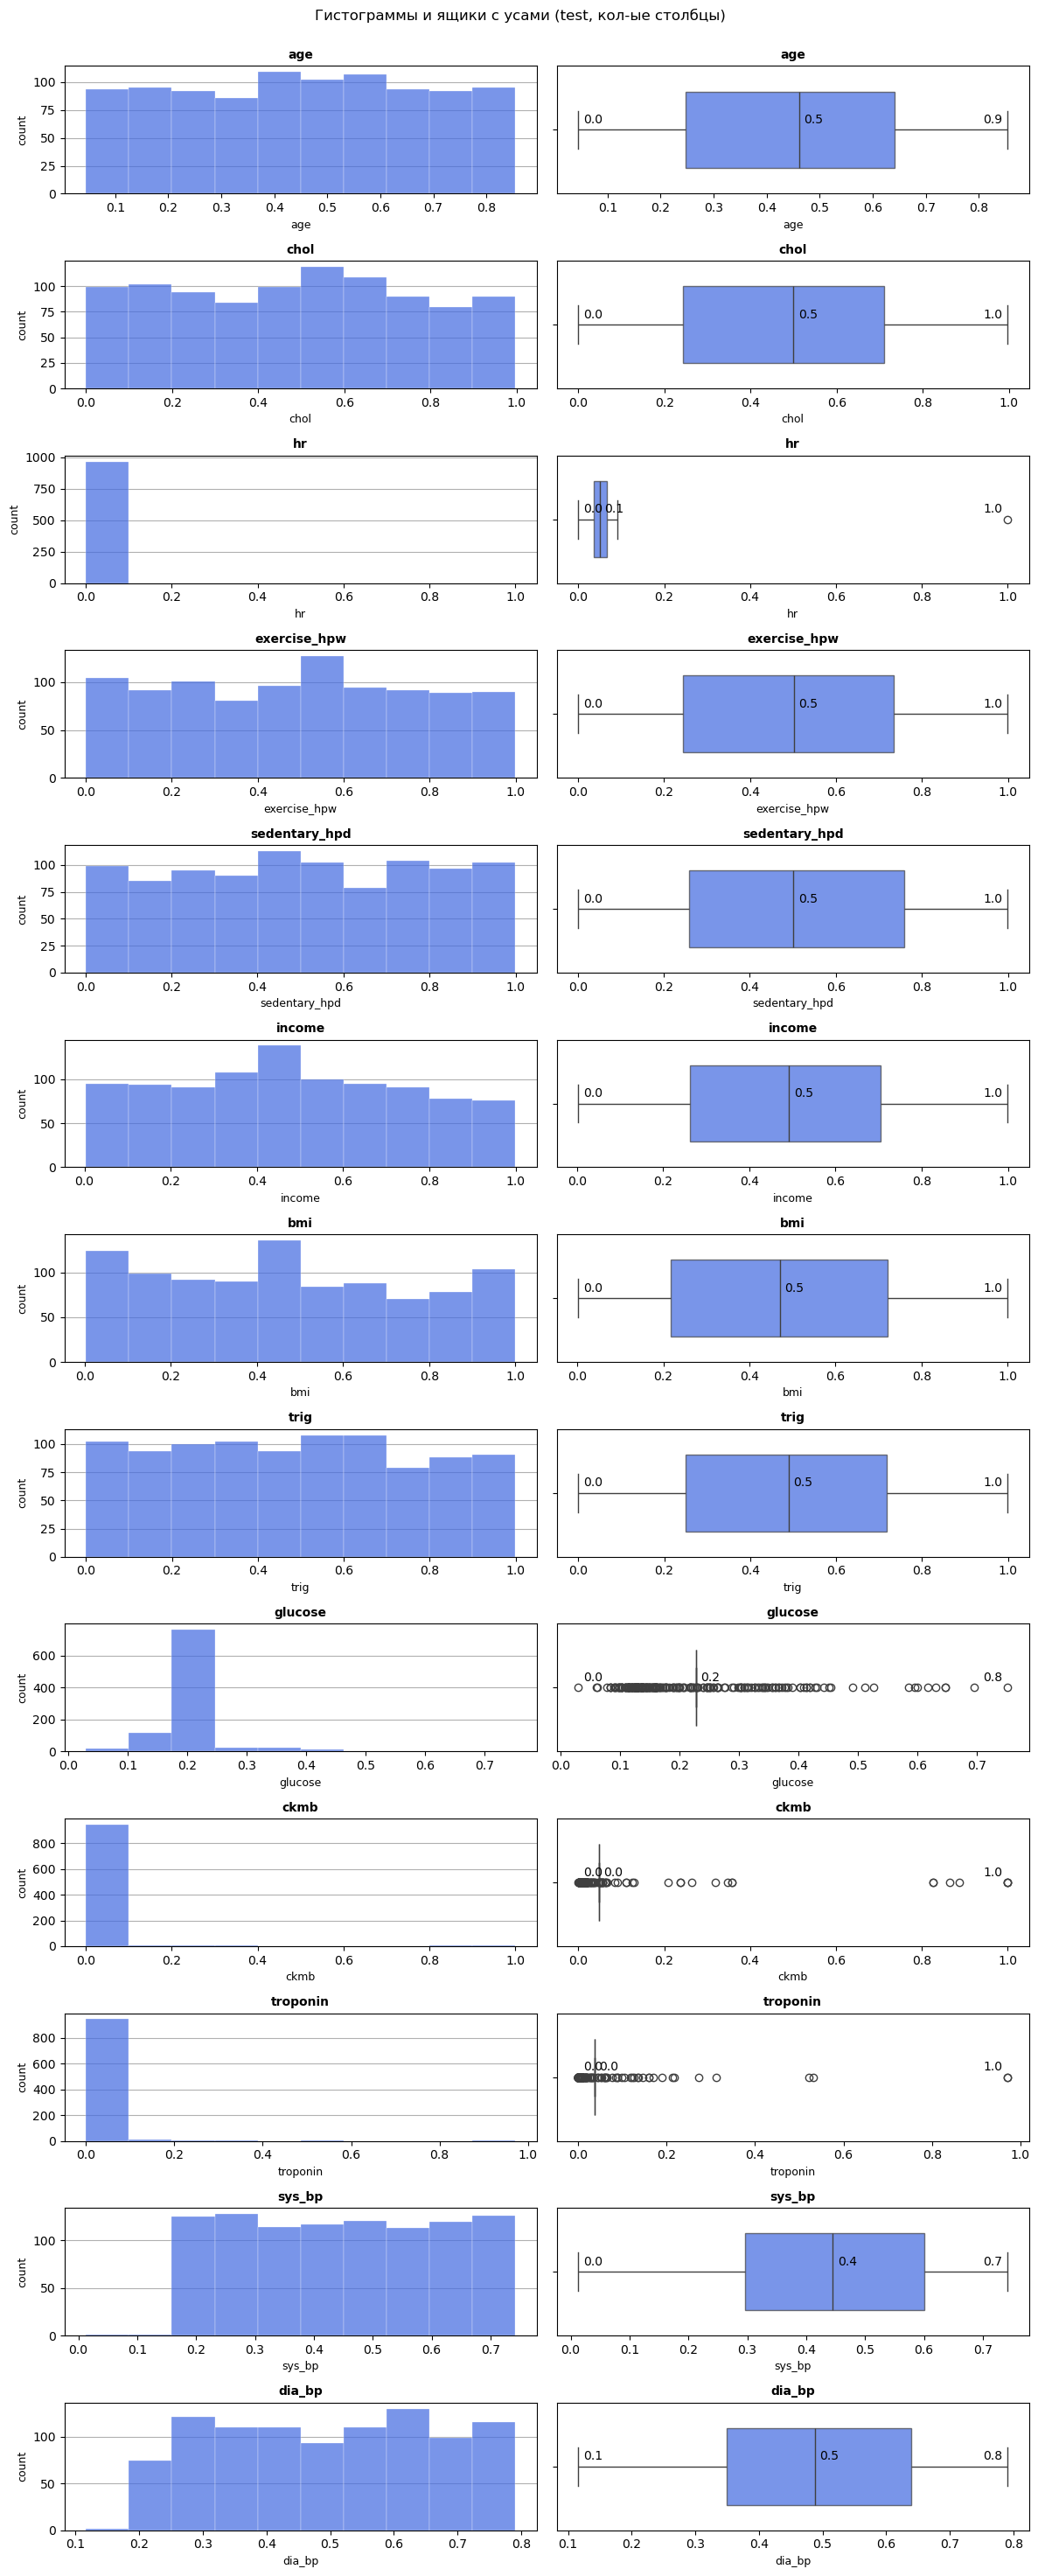

In [35]:
# Гистограммы и ящики с усами
cols = num_cols_cont
titles = cols.copy()
x_labels = cols.copy()
fig, axes = plt.subplots(13, 2, figsize=(12, 30))
axes = axes.flatten()
draw_histboxes(df2, axes, titles, x_labels, cols=cols)
plt.suptitle('Гистограммы и ящики с усами (test, кол-ые столбцы)')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Как и в train, в test есть длинные хвосты справа в `glucose`(также в `ckmb`, `troponin`, но их мы удалили)  
Также есть выброс справа у `hr`.  
Но наблюдения в test мы в любом случае не удаляем.

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Корреляционный анализ

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Построим матрицы корреляции.

In [36]:
interval_cols = num_cols_cont.copy()
not_interval_cols = [x for x in df1.columns if x not in interval_cols]

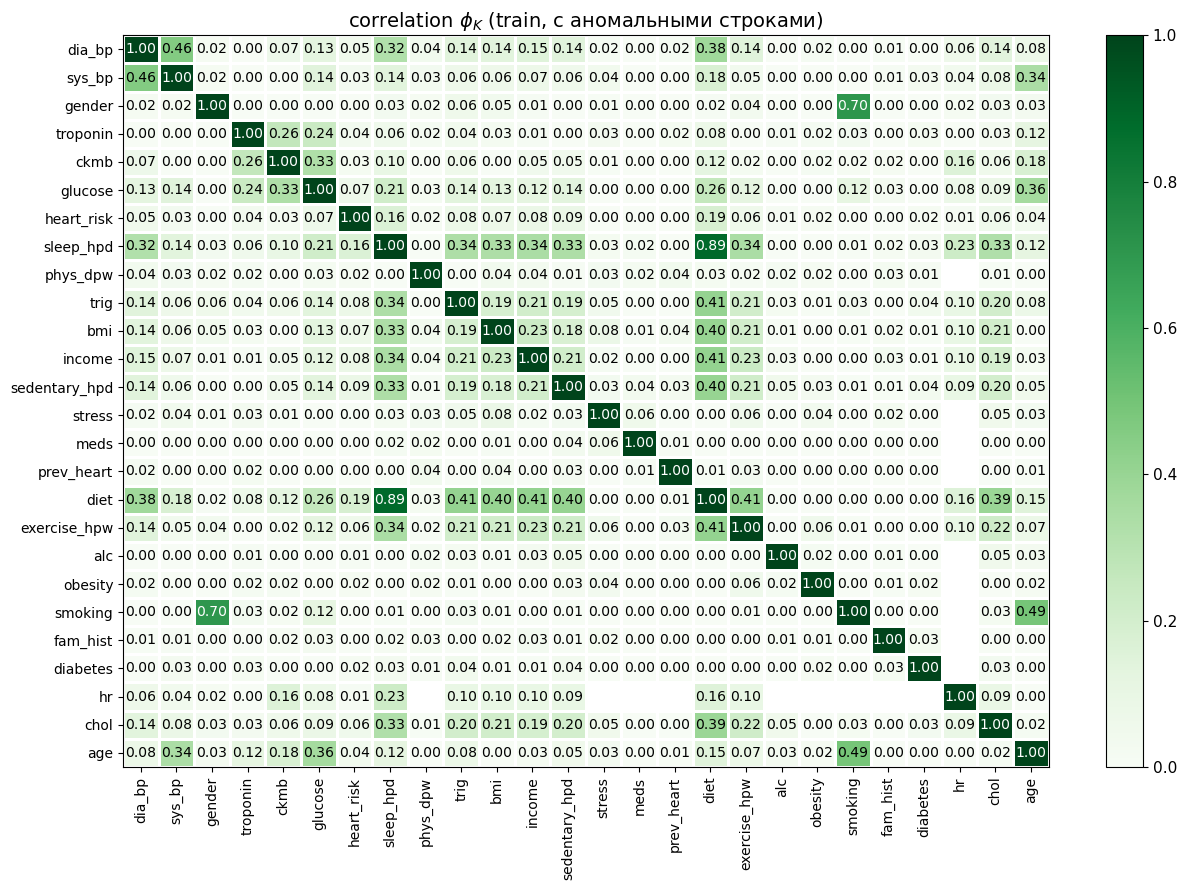

In [37]:
# train, с аномальными строками
matrix = phik_matrix(df1, interval_cols=interval_cols)
plot_correlation_matrix(matrix.values,
                        x_labels=matrix.columns,
                        y_labels=matrix.index,
                        fontsize_factor=1,
                        figsize=(13,9),
                        vmin=0, vmax=1,
                        color_map='Greens',
                        title=r'correlation $\phi_K$ (train, с аномальными строками)')
plt.gcf().axes[-1].tick_params(labelsize=11)  # доставем текущую фигуру и берем последнюю ось

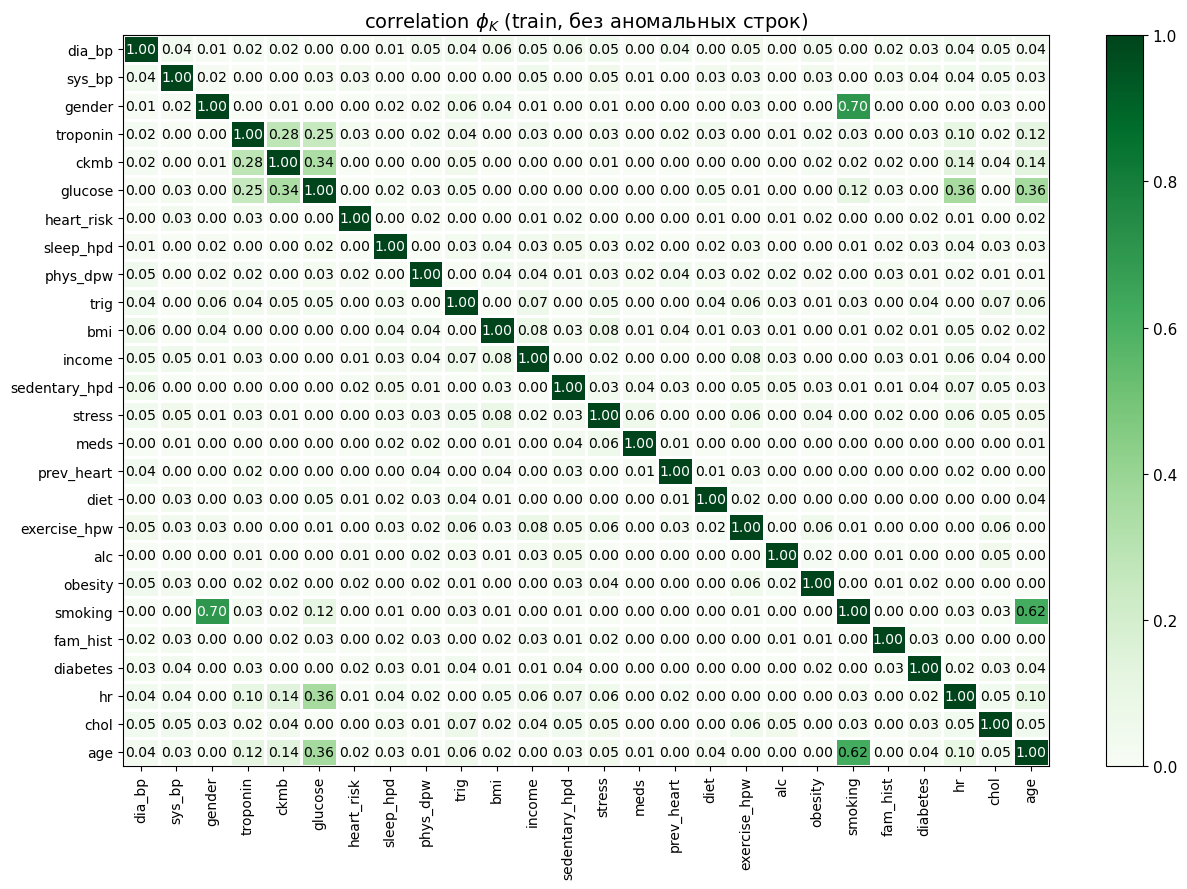

In [38]:
# train, без аномальных строк
matrix = phik_matrix(df1.loc[df1['diabetes'].notna()], interval_cols=interval_cols)
plot_correlation_matrix(matrix.values,
                        x_labels=matrix.columns,
                        y_labels=matrix.index,
                        fontsize_factor=1,
                        figsize=(13,9),
                        vmin=0, vmax=1,
                        color_map='Greens',
                        title=r'correlation $\phi_K$ (train, без аномальных строк)')
plt.gcf().axes[-1].tick_params(labelsize=11)  # доставем текущую фигуру и берем последнюю ось

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

1. Становится очевидно, что данные синтетические:
    - `bmi` и `obecity` должны коррелировать между собой, а мы видим корреляцию 0
    - `phys_dpd` и `excercise_hpw` тоже должны коррелировать между собой, но корреляция 0
2. Если удалить аномальные наблюдения, то корреляций практически нет, корреляции с целевым близки к 0, это означает, что скорее всего мы не сможем получить хорошие прогнозы.  
   Если аномальные наблюдения не удалять, то картина лучше, например:
     - 0.15 с `sleep_hpd`
     - 0.19 с `diet`

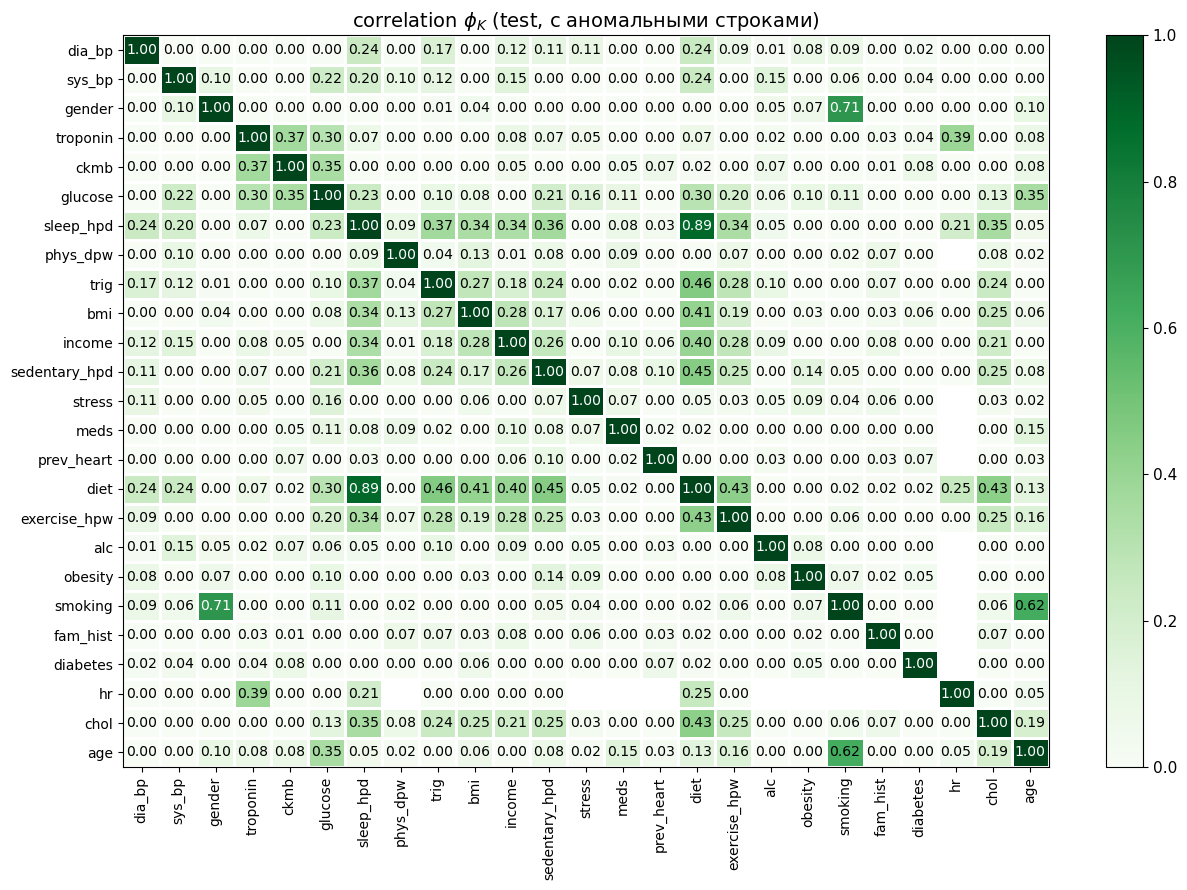

In [39]:
# test, с аномальными строками
matrix = phik_matrix(df2, interval_cols=interval_cols)
plot_correlation_matrix(matrix.values,
                        x_labels=matrix.columns,
                        y_labels=matrix.index,
                        fontsize_factor=1,
                        figsize=(13,9),
                        vmin=0, vmax=1,
                        color_map='Greens',
                        title=r'correlation $\phi_K$ (test, с аномальными строками)')
plt.gcf().axes[-1].tick_params(labelsize=11)  # доставем текущую фигуру и берем последнюю ось

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
# Модели

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Этапы построения модели и результаты по этому блоку:

1. **Пайплайн**
    - Убираем столбцы-утечки (`troponin` и `ckmb`)
    - Преобразовываем оставшиеся столбцы (масштабирование и кодирование не делаем т.к. данные уже масштабированы и закодированы)
        - исправляем пол
        - заполняем пропуски в кол-ых и кат-ых признаках медианой
        - заполняем пропуски в булевых признаках самым распространенным значением
    - Добавляем шаг с моделью
2. **Группы признаков**: разбиваем признаки на группы так, чтобы из было удобно передавать в пайплайн
    - `num_cols`, `cat_cols`, `bool_cols`, `gender_col`
    - `leak_cols` и полный список столбцов для исключения: `cols_to_remove`
3. **Исключаем** признаки-утечки и признаки с минимальным влияем, выявленным в блоке Permutation importance
4. **Фильтруем** значения чтобы убрать выбросы
   - оставляем только `hr`<0.5 и `glucose`<0.6
6. **Выбираем метрику** - в качестве целевой метрики берем **ROC-AUC**, потому что он без учета порога показывает обсую способность модели разделять классы.
7. **Подбор гипперпараметров для моделей** - через **OptunaSearchCV** подбираем гиперпараметры для 3х моделей:
    - RandomForestClassifier
    - LGBMClassifier
    - CatBoostClassifier
8. **Выбираем лучшую модель** на основе нашей метрики ROC-AUC
   > Выбран **CatBoostClassifier**, а две другие модели в коде закомментированы
9. **Порог** подбираем на основе валидационной выборки для максимизации **F1**
    > Порог выбран **0.55**
11. **Метрики на тесте**: проверяем все важные метрики  на тестовой выборке
12. **Предсказания**: строим предсказания на финальной тестовой выборке



<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Обучение

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Пайплайн

In [40]:

def build_pipeline(num_cols, ord_cols, bool_cols, gender_col, leak_cols, model):
    transformers = []
    dropper = FunctionTransformer(drop_leak, kw_args={'leak_cols': leak_cols})
    gender_transformer = Pipeline([
        ('fix', FunctionTransformer(fix_gender)),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])

    if len(gender_col) > 0:
        transformers.append(
            ('gender_transformer',
              gender_transformer,
              gender_col)
        )
    if len(num_cols + ord_cols) > 0:
        transformers.append(
            ('imputer_median',
              SimpleImputer(missing_values=np.nan, strategy='median'),
              num_cols + ord_cols)
        )
    if len(bool_cols) > 0:
        transformers.append(
            ('imputer_mostfreq',
              SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
              bool_cols)
        )
    
    data_processor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )

    return Pipeline([
        ('dropper', dropper),
        ('processor', data_processor),
        ('model', model)
    ])

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Признаки: отбор и фильтрация

In [41]:
# Задаем списки столбцов по типам
num_cols = [
    'age', 'hr', 'exercise_hpw', 'sedentary_hpd', 'income', 'bmi', 'trig', 'glucose', 'sys_bp', 'dia_bp', 'ckmb', 'troponin', 'chol',     # num_cols_cont
    'phys_dpw', 'sleep_hpd'  # кол-ые дискретные (причем 'phys_dpw' не масштабирован)
]
ord_cols = ['stress', 'diet']
bool_cols = ['meds', 'prev_heart', 'diabetes', 'smoking', 'obesity', 'alc', 'fam_hist']
gender_col = ['gender']
target = 'heart_risk'

# Задаем столбцы для удаления
leak_cols = ['ckmb', 'troponin']
to_remove = leak_cols + ['diet', 'smoking']

def remove_features(col_list, to_remove):
    return [col for col in col_list if col not in to_remove]

# Итоговые колонки с фильтрацией
num_cols = remove_features(num_cols, to_remove)
ord_cols = remove_features(ord_cols, to_remove)
bool_cols = remove_features(bool_cols, to_remove)
gender_col = remove_features(gender_col, to_remove)

In [42]:
# Убираем выбросы
df1 = df1.loc[df1['hr']<0.5]
df1 = df1.loc[df1['glucose']<0.6]

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Подготовка

In [43]:
X = df1.drop('heart_risk', axis=1)
y = df1['heart_risk']
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train_val
)
X_test_final = df2.copy()

print('X_train:', X_train.shape, '  y_train:', y_train.shape)
print('X_val:', X_val.shape, '  y_val:', y_val.shape)
print('X_test:', X_test.shape, '  y_test:', y_test.shape)
print('X_test_final:', X_test_final.shape)

X_train: (5154, 25)   y_train: (5154,)
X_val: (1289, 25)   y_val: (1289,)
X_test: (2148, 25)   y_test: (2148,)
X_test_final: (966, 25)


In [44]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [45]:
# Функция создает пайплайн и возвращает обученный экземпляр OptunaSearchCV
def run_optuna_search(model_class, model_kwargs, params, X_train, y_train):
    pipe = build_pipeline(
        num_cols, ord_cols, bool_cols, gender_col, leak_cols,
        model_class(**model_kwargs)
    )
    opt = OptunaSearchCV(
        pipe,
        params,
        n_trials=500,
        scoring='roc_auc',
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    opt.fit(X_train, y_train)
    return opt

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### DecisionTreeClassifier

In [46]:
# %%time
# # DecisionTreeClassifier
# params_dt = {
#     'model__max_depth': IntDistribution(3, 21, 1),
#     'model__min_samples_split': IntDistribution(2, 50, 1),
#     'model__min_samples_leaf': IntDistribution(1, 50, 1),
#     'model__class_weight': CategoricalDistribution(["balanced", None]),
# }

# opt_dt = run_optuna_search(
#     DecisionTreeClassifier,
#     {'random_state':RANDOM_STATE},
#     params_dt,
#     X_train,
#     y_train
# )

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### RandomForestClassifier

In [47]:
# %%time
# # RandomForestClassifier
# params_rf = {
#     'model__n_estimators': IntDistribution(100, 2000, step=50),
#     'model__max_depth': IntDistribution(3, 30),
#     'model__min_samples_split': IntDistribution(2, 20),
#     'model__min_samples_leaf': IntDistribution(1, 20),
#     'model__max_features': CategoricalDistribution(['sqrt', 'log2', None]),  # 0.5, None
#     'model__bootstrap': CategoricalDistribution([True, False]),
#     'model__class_weight': CategoricalDistribution([None, 'balanced', 'balanced_subsample'])
# }
# opt_rf = run_optuna_search(
#     RandomForestClassifier,
#     {'random_state':RANDOM_STATE,
#      'n_jobs':-1},
#     params_rf,
#     X_train,
#     y_train
# )

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### LGBMClassifier

In [48]:
# %%time
# # LGBMClassifier
# params_lgbm = {
#     'model__n_estimators': IntDistribution(100, 2000, step=50),
#     'model__learning_rate': FloatDistribution(0.005, 0.1, log=True),   # (0.005, 0.2, log=True)
#     'model__max_depth': IntDistribution(3, 30),                       # -1 тоже можно оставить вручную
#     'model__num_leaves': IntDistribution(31, 512),                    # (16, 512)
#     'model__min_child_samples': IntDistribution(5, 50),               # (5, 100)
#     'model__min_child_weight': FloatDistribution(0.001, 10),
#     'model__subsample': FloatDistribution(0.5, 1.0),
#     'model__colsample_bytree': FloatDistribution(0.5, 1.0),
#     'model__reg_alpha': FloatDistribution(1e-8, 1, log=True),         # (1e-8, 10.0, log=True)
#     'model__reg_lambda': FloatDistribution(1e-8, 1, log=True),        # (1e-8, 10.0, log=True)
#     'model__min_split_gain': FloatDistribution(0.0, 1.0),
#     'model__subsample_freq': IntDistribution(1, 10),
#     'model__class_weight': CategoricalDistribution([None, 'balanced'])
# }
# opt_lgbm = run_optuna_search(
#     lgb.LGBMClassifier,
#     {'random_state':RANDOM_STATE,
#      'verbose':-1},
#     params_lgbm,
#     X_train,
#     y_train
# )

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### CatBoostClassifier

In [ ]:
%%time
# CatBoostClassifier
params_cb = {
    'model__iterations': IntDistribution(100, 1100, step=50),
    'model__depth': IntDistribution(3, 12),
    'model__learning_rate': FloatDistribution(0.005, 0.1, log=True),
    'model__l2_leaf_reg': FloatDistribution(1, 30),
    'model__rsm': FloatDistribution(0.2, 1.0),
    'model__subsample': FloatDistribution(0.5, 1),
    'model__loss_function': CategoricalDistribution(['Logloss', 'CrossEntropy']),
    'model__class_weights': CategoricalDistribution(([{0:1, 1:w} for w in [0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4]]))
}
opt_cb = run_optuna_search(
    CatBoostClassifier,
    {'early_stopping_rounds':50,
     'random_state':RANDOM_STATE,
     'verbose':0,
     'thread_count':1},
    params_cb,
    X_train,
    y_train
)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Лучший ROC-AUC на кросс-валидации

In [ ]:
# Results
runs = [opt_cb]  # [opt_rf, opt_lgbm, opt_cb]
results = []
for run in runs:
    results.append({
        'model': run.best_estimator_.named_steps['model'].__class__.__name__,
        'best_score': run.best_score_,
        'best_params': run.best_params_
    })
results = pd.DataFrame(results).sort_values(by='best_score', ascending=False)
results.style.set_properties(**{'text-align':'left'})

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Импорт/экспорт модели

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Здесь мы либо:
1. Либо выбрать лучшую модель на основе нашей метрики ROC-AUC, экспортируем в папку
2. Либо импортировать ранее сохраненную модель

Далее смотрим предсказания на трейне - это непоказательно, однако показывает степень переобученности модели.

In [ ]:
MODE = 'save_and_use_new_model'   # save_and_use_new_model / 'use_previosly_saved_model'
MODEL_PATH = "../app/model_with_threshold.pkl"

if MODE == 'save_and_use_new_model':
    best_run = max(runs, key=lambda x: x.best_score_)
    best_model = best_run.best_estimator_
    threshold = 0.2
    model_dic = {
        'model': best_model,
        'threshold': threshold
    }
    joblib.dump(model_dic, MODEL_PATH)
    print(f"Модель сохранена и используется: {MODEL_PATH}")

elif MODE == 'use_previosly_saved_model':
    model_dic = joblib.load(MODEL_PATH)
    best_model = model_dic['model']
    threshold = model_dic['threshold']
    print(f"Загружена ранее сохранённая модель: {MODEL_PATH}")


# смотрим предсказания на трейне
y_pred_proba = best_model.predict_proba(X_train)[:,1]
y_pred = y_pred_proba > 0.50
print_metrics(y_train, y_pred, y_pred_proba)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Подбор порога

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Подберем порог на графике. Это сложно учитывая синтетические данные.  

- Если решать задачу академически, то для достижения максимального Recall =1 нужно выбрать порог =0.2.

In [ ]:
y_pred_proba = best_model.predict_proba(X_val)[:,1]

thresholds = [round(i,2) for i in np.linspace(0.01, 0.99, num=100, endpoint=True)]
metrics = {
    'F1-score': {'color': 'black', 'values': []},     # 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white'
    'F2-score': {'color': 'blue', 'values': []},
    'Recall': {'color': 'red', 'values': []},
    'Precision': {'color': 'green', 'values': []},
    'Accuracy': {'color': 'cyan', 'values': []},
    'Share of 1': {'color': 'magenta', 'values': []},
}
best_recall = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = y_pred_proba > threshold
    recall = recall_score(y_val, y_pred, zero_division=0)
    metrics['F1-score']['values'].append(f1_score(y_val, y_pred, zero_division=0)*100)
    metrics['F2-score']['values'].append(fbeta_score(y_val, y_pred, beta=2, zero_division=0)*100)
    metrics['Recall']['values'].append(recall*100)
    metrics['Precision']['values'].append(precision_score(y_val, y_pred, zero_division=0)*100)
    metrics['Accuracy']['values'].append(accuracy_score(y_val, y_pred)*100)
    metrics['Share of 1']['values'].append(sum(y_pred)/len(y_pred)*100)
    if recall >= best_recall:
        best_recall = recall
        best_threshold = threshold

print(f"Лучший recall: {best_recall} достигается при пороге {best_threshold}")
    
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for name, data in metrics.items():
    ax.plot(thresholds,
            data['values'],
            label=name,
            linestyle='-',
            linewidth=2,
            marker='o',
            color=data['color']
           )
ax.set_title('Сравнение метрик модели для разных порогов')
ax.set_xlabel('Порог')
ax.set_ylabel('Значение метрик, %')
ax.set_ylim(0,100)
ax.grid(True)
ax.legend()
plt.tight_layout()

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Результаты на тесте

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

ROC-AUC на тесте практически не отличается от показателя на кроссвалидации

In [ ]:
# результаты на тесте
y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred = y_pred_proba > 0.2
print_metrics(y_test, y_pred, y_pred_proba)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Сохранение предсказаний и порога

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Сохраняем предсказания для итогового теста

In [ ]:
y_pred_proba = best_model.predict_proba(X_test_final)[:,1]
y_pred = y_pred_proba > 0.2
df_preds = pd.DataFrame({
    'id': X_test_final.index,
    'prediction': y_pred.astype(int)
})
df_preds.to_csv("../predictions/predictions.csv", index=False)

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">

Тут можно заменить threshold в сохраненной модели

In [ ]:
# model_dic['threshold'] = 0.3
# joblib.dump(model_dic, MODEL_PATH)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
## Анализ важности признаков

In [ ]:
col_names = gender_col + num_cols + ord_cols + bool_cols
X_val_transformed = best_model[:-1].transform(X_val)  # сначала трансформируем X_train
X_val_transformed = pd.DataFrame(X_val_transformed, columns=col_names)
best_model_short = best_model.named_steps['model']                     # берем из лучшей модели только саму модель, без трансформеров

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### Permutation Importance

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">
    
На предыдущем этапе важность признаков была такая, поэтому убрали признаки `diet` и `smoking`

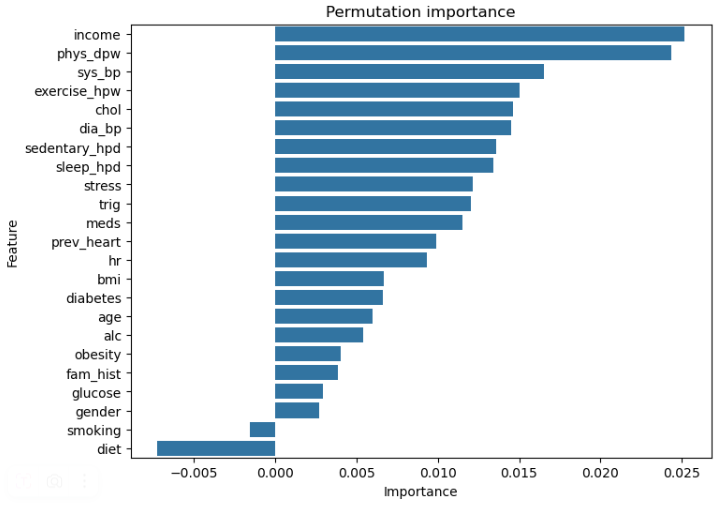

In [ ]:
perm_imp = permutation_importance(
    best_model_short,
    X_val_transformed.values,
    y_val,
    scoring='f1',
    n_repeats=5,
    random_state=RANDOM_STATE
)
feature_importance = pd.DataFrame(
    {'Feature': col_names,
     'Importance': perm_imp.importances_mean
    }).sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=feature_importance,
            x='Importance',
            y='Feature',
            orient='h',
            ax=ax
           )
ax.set_title('Permutation importance')
plt.show()

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
### SHAP

In [ ]:
X_sample = X_val_transformed.sample(500, random_state=RANDOM_STATE)  # берем только sample чтобы SHAP считался быстрее

X_pool = Pool(X_sample, feature_names=list(X_sample.columns))
shap_values = best_model_short.get_feature_importance(type='ShapValues', data=X_pool)
shap_values = shap_values[:,:-1]

expl = shap.Explanation(
    values=shap_values,
    base_values=np.zeros(shap_values.shape[0]),  # baseline, CatBoost возвращает последний столбец отдельно
    data=X_sample.values,
    feature_names=X_sample.columns.tolist()
)

shap.plots.bar(expl, max_display=25, show=True)

<div style="background: #00264d; padding: 10px; border-radius: 10px;  color: white; ">
    
# Выводы

<div style="background: #fafafa;
    padding: 20px;
    border-left: 20px solid #00264d;
    border-top: 1px solid #ccc;
    border-right: 1px solid #ccc;
    border-bottom: 1px solid #ccc;
    border-radius: 15px;">
    
Этапы построения модели и результаты по этому блоку:

1. **Исследовательский анализ**
   - Почти все признаки уже масштабированы: принимают значени от 0 до 1. Кроме диеты, стресса, физ.активности и пола. Дп.масштабирование не делаем т.к. для деревьев это не обязательно.
   - Проверили, что id уникальны, полных дублей в данных нет, убрали столбец `Unnamed: 0`и сделали столбец `id` индексом в каждом датасете
   - Есть небольшой дисбаланс классов - 36% с таргетом 1, 64% - с таргетом 0
   - Есть длинные правые хвосты, похожие на выбросы у `glucose`, `ckmb`, `troponin`, выбросы в `hr`
   - В данных есть "аномальные" строки (2,8% в тренировочных и 3,2% в тестовых данных) - именно в этих строках часть признаков пропущены, а часть предзаполнены, во всех этих строках риск инфаркта - 0. В обычной ситуации их нужно было бы удалить, но без них значительно снижаются корреляции между признаками, поэтому оставляем эти аномалии.
   - Корреляции между признаками (в том числе с целевым) крайне низкие, что предвосхищает не самые лучшие результаты моделей   


2. **Предобработка данных**
   - в пайплайне:
       - убираем признаки-утечки `troponin` и `ckmb`
       - приводим `gender_col` к значению
       - заполняем пропуски в кол-ых и кат-ых признаках медианой, в будевых - самым распространенным значением
   - избавляемся от маловажных признаков
   - убираем выбросы в тренировочном датасете (оставляем `hr`<0.5 и `glucose`<0.6)  


3. **Модель**
   - В качестве целевой метрики берем **ROC-AUC**
   - Среди RandomForestClassifier, LGBMClassifier и **CatBoostClassifier** выбираем последний
   - Подбор гиперпараметров - через **OptunaSearchCV**  


4. **Порог**
   - Выбираем порог 0.55 исходя из задачи максимизации Recall одновременно с балансировкой F1  


5. **Метрики**
   - ROC-AUC на кросс-валидации **0.58**, на тесте тоже **0.58**
   - Другие метрики на тесте: F1: **ХХХ**, Recall: **ХХХ**, Precision: **ХХХ**, доля предсказанного класса 1: **ХХХ**  


6. **Сохраненные артефакты**
   - **Предсказания** сохранены в `файле predictions.csv`
   - **Словарь c `model` и `threshold`** сохранен в `models/best_model_with_threshold.pkl`
   - **Приложение** для определения риска инфаркта по данным 1 пациента: `app.py`